In this notebook, we show the dynamical relaxation time and plot out a few contours.

# Init

In [1]:
from __future__ import division

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys,os
sys.path.insert(1, os.path.join(sys.path[0], '..'))

In [4]:
from matplotlib import rcParams, rc

In [5]:
import spc
import model
import chi2
import margin
import tools as tl

import numpy as np
import matplotlib
%matplotlib notebook
import matplotlib.pyplot as plt
from scipy.integrate import quad
import h5py
import glob
import re

import scan
import pickle
import glob
from multiprocessing import Pool
from contextlib import closing

from matplotlib import cm
from tqdm import tqdm

In [6]:
plt.rcParams.update({'font.size': 12})

In [7]:
path = '../data/SPARC.txt'
data = spc.readSPARC(path)

path = '../data/SPARC_Lelli2016c.txt'
spc.readSPARC_ext(data, path)

In [8]:
data2 = {}
for gal in data:
    data2[gal.name] = gal

# Functions

moved to the corresponding .py file

In [27]:
# def model.tau(f, m, v=57., rho=0.003):
#     """ relaxation time computation [Gyr]
#     :param f: fraction
#     :param m: scalar mass [eV]
#     :param v: dispersion [km/s]
#     :param rho: DM density [Msun/pc**3]    
    
#     """
#     return 0.6 * 1./f**2 * (m/(1.e-22))**3 * (v/100)**6 * (rho/0.1)**(-2)

# model.tau(0.2, 1e-22, 100, 0.1) 

In [11]:
# def reconstruct_density(gal, flg_give_R=False):
#     """ reconstruct the local density based on the rotaion curve
    
#     """
#     V = gal.Vobs
#     r = gal.R
#     M_unit = 232501.397985234 # Msun computed with km/s, kpc
#     M = V**2 * r * M_unit
#     r_mid = (r[1:] + r[:-1]) /2.
#     dr = r[1:] - r[:-1]
#     rho = (M[1:] - M[:-1]) / 4./np.pi/r_mid**2 / dr /1e9 #[Msun/pc**3]
#     if flg_give_R:
#         return (r_mid, rho)
#     else:
#         return rho

# Check the data

In [32]:
#gal = data2['UGC01281']
gal = data2['UGC04325']
print(gal.Vobs[-1])
model.reconstruct_density_DM(gal)

91.5


(<function model.rho>, 4.224489795918368, 20.716983998953076)

<IPython.core.display.Javascript object>


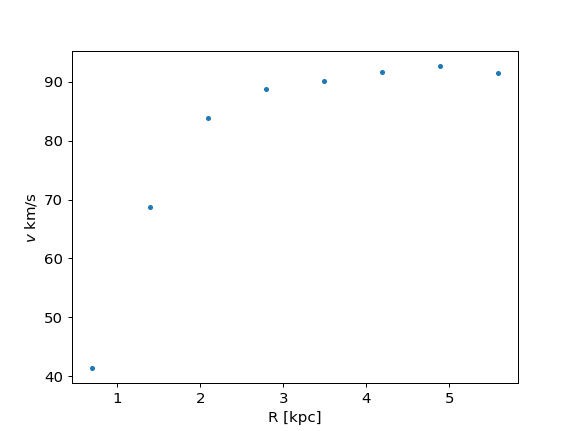

Text(0,0.5,'$v$ km/s')

In [33]:
plt.subplots()
plt.plot(gal.R, gal.Vobs, '.')
plt.xlabel('R [kpc]')
plt.ylabel(r'$v$ km/s')

<IPython.core.display.Javascript object>


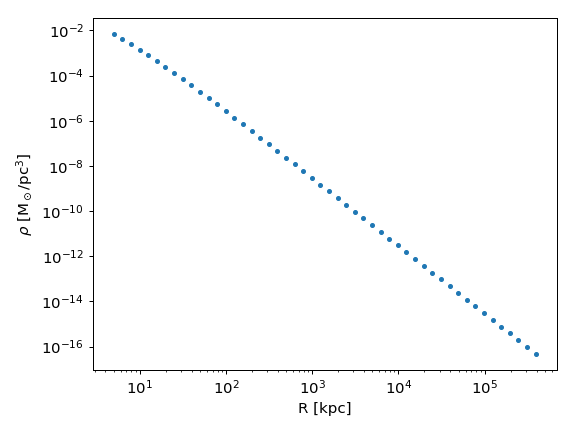

In [40]:
fn, _, _ = model.reconstruct_density_DM(gal)
plt.subplots()
r_arr = np.logspace(gal.R[0], gal.R[-1])
plt.plot(r_arr, fn(r_arr), '.')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('R [kpc]')
plt.ylabel(r'$\rho$ [M$_\odot$/pc$^3$]')
plt.tight_layout()

<IPython.core.display.Javascript object>


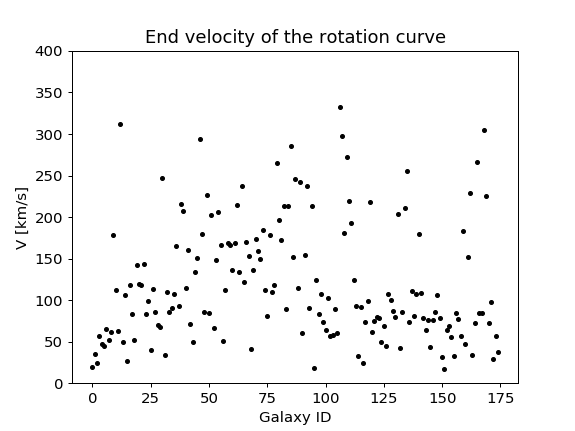

Text(0.5,1,'End velocity of the rotation curve')

In [43]:
vf_arr = []
rhof_arr = []

for gal in data:
    v_f = gal.Vobs[-1]
    vf_arr.append(v_f)
    fn,_,_ = model.reconstruct_density_DM(gal)
    rhof_arr.append(fn(gal.R[-1]))    
    
plt.subplots()
plt.plot(vf_arr, 'k.')
plt.ylim(0, 400)
plt.xlabel('Galaxy ID')
plt.ylabel('V [km/s]')
plt.title('End velocity of the rotation curve')

<IPython.core.display.Javascript object>


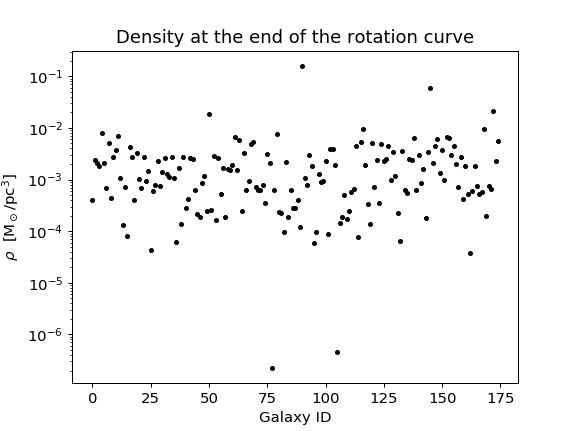

Text(0.5,1,'Density at the end of the rotation curve')

In [44]:
plt.subplots()
plt.plot(rhof_arr, 'k.')
plt.yscale('log')
plt.xlabel('Galaxy ID')
plt.ylabel(r'$\rho$  [M$_\odot$/pc$^3$]')
plt.title('Density at the end of the rotation curve')

<IPython.core.display.Javascript object>


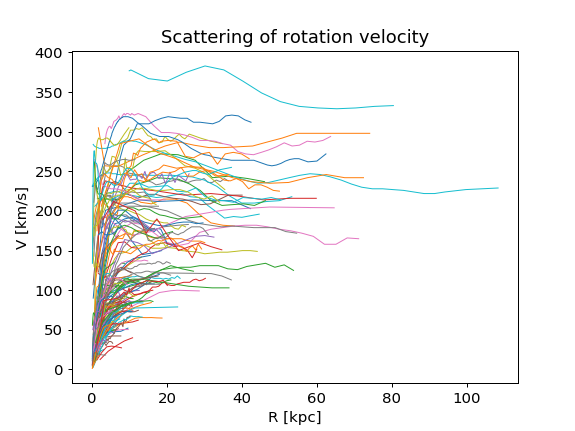

In [45]:
plt.subplots()
plt.title("Scattering of rotation velocity")
plt.xlabel('R [kpc]')
plt.ylabel('V [km/s]')

for name, gal in data2.items():
    plt.plot(gal.R, gal.Vobs, lw='0.8')

# Relaxatin time at last data point

In [46]:
f1 = 0.85
f2 = 0.15
m1_arr = np.logspace(-25, -19, 100)
m2_arr = np.logspace(-25, -19, 100)

m1_mesh, m2_mesh = np.meshgrid(m1_arr, m2_arr, indexing='ij')
m1_flat, m2_flat = m1_mesh.reshape(-1), m2_mesh.reshape(-1)

In [47]:
gal = data2['UGC04325']

In [58]:
tau1_flat = []
tau1_self_flat = []

for i in range(len(m1_flat)):
    m1 = m1_flat[i]
    m2 = m2_flat[i]
    
    R = gal.R[-1]
    sigma = model.sigma_disp_over_vcirc(gal, gal.R[-1]) * gal.Vobs[-1]
    rho_fn, _, _ = model.reconstruct_density_DM(gal)
    rho = rho_fn(gal.R[-1])
    cut_log=True
    
    tau1 = 1./(1./model.tau(f1, m1, sigma, rho, R, cut_log=cut_log) + 1./model.tau(f2, m2, sigma, rho, R, cut_log=cut_log))
    tau1_self = model.tau(f1, m1, sigma, rho, R, cut_log=cut_log) 
    
    tau1_flat.append(tau1)
    tau1_self_flat.append(tau1_self)
    
tau1_flat = np.asarray(tau1_flat)
tau1_self_flat = np.asarray(tau1_self_flat)

tau1_mesh = tau1_flat.reshape(m1_mesh.shape)
tau1_self_mesh = tau1_self_flat.reshape(m1_mesh.shape)

<IPython.core.display.Javascript object>


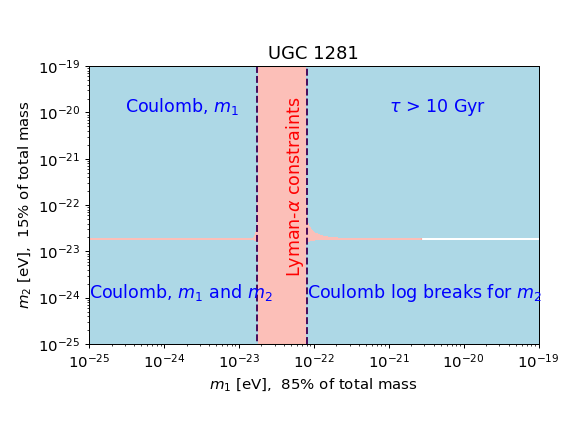

In [70]:
_, ax = plt.subplots()
plt.contourf(m1_mesh, m2_mesh, tau1_mesh, levels=[10, np.inf], colors='lightblue')
plt.contour(m1_mesh, m2_mesh, tau1_self_mesh, levels=[10], linestyles={'dashed'})
plt.fill_betweenx(np.logspace(-25, -19), 1e-25, 2.66e-21, color='salmon', alpha=0.5, zorder=0)

#label
plt.text(4e-23, 1e-20, r"Lyman-$\alpha$ constraints", color='red', fontsize=14, rotation=90)
plt.text(1e-21, 1e-20, r"$\tau$ > 10 Gyr", color='blue', fontsize=14)
plt.text(8e-23, 1e-24, r"Coulomb log breaks for $m_2$", color='blue', fontsize=14)
plt.text(1e-25, 1e-24, r"Coulomb, $m_1$ and $m_2$", color='blue', fontsize=14)
plt.text(3e-25, 1e-20, r"Coulomb, $m_1$", color='blue', fontsize=14)


plt.xscale('log')
plt.yscale('log')
plt.xlabel('$m_1$ [eV],  85% of total mass')
plt.ylabel('$m_2$ [eV],  15% of total mass')
plt.xlim(1e-25, 1e-19)
plt.ylim(1e-25, 1e-19)
plt.title(r"UGC 1281")
ax.set_aspect(aspect=0.618)
plt.tight_layout()
#plt.savefig('./sol_relaxation_contour.pdf')

In [37]:
# check relaxation time at the last data point

In [83]:
gal

In [91]:
#f1 = 0.85
f1 = 1.
m1_target_arr = []
vf_arr = []
rhof_arr = []
m1_arr = np.logspace(-25, -19, 100)

for gal in data:
    fn, _, _ = model.reconstruct_density_DM(gal) # last data point is selected
    rho_f = fn(gal.R[-1])
    v_f = gal.Vobs[-1] # last data point
    vf_arr.append(v_f)
    rhof_arr.append(rho_f)
    tau1_self_arr = []    
    
    for m1 in m1_arr:
        R = gal.R[-1]
        sigma = model.sigma_disp_over_vcirc(gal, gal.R[-1]) * gal.Vobs[-1]
        cut_log=True        
        
        tau1_self = model.tau(f1, m1, sigma=sigma, rho=rho_f, R=gal.R[-1], cut_log=cut_log) 
        tau1_self_arr.append(tau1_self)
    tau1_self_arr = np.asarray(tau1_self_arr)
    #print(tau1_self_arr)
    mask = np.where(tau1_self_arr < 1000, True, False)
    #print(mask)
    if sum(mask) > 0:
        m1_target = np.exp(np.interp(np.log(10), np.log(tau1_self_arr[mask]), np.log(m1_arr[mask])))
        m1_target_arr.append(m1_target)

This is the result with coulomb log > 1. 

<IPython.core.display.Javascript object>


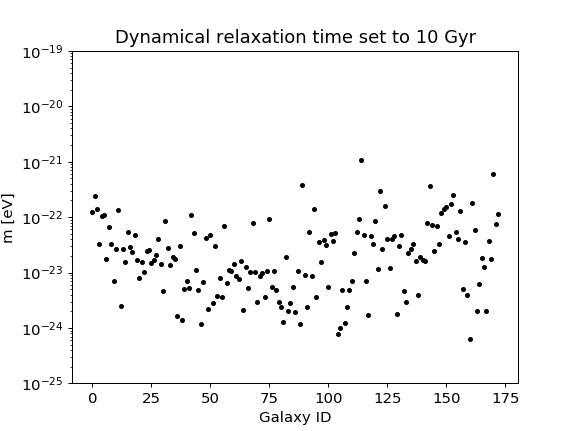

Text(0.5,1,'Dynamical relaxation time set to 10 Gyr')

In [92]:
plt.subplots()
plt.plot(m1_target_arr, 'k.')
plt.yscale('log')
plt.ylim(1e-25, 1e-19)
plt.xlabel('Galaxy ID')
plt.ylabel('m [eV]')
plt.title('Dynamical relaxation time set to 10 Gyr')

<IPython.core.display.Javascript object>


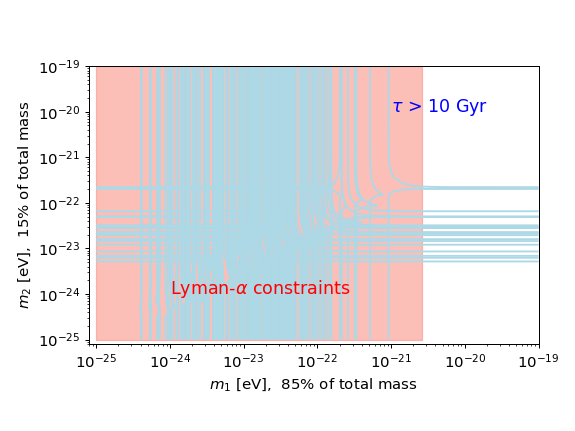

/a/home/cc/students/physics/chensun/app/anaconda2/lib/python2.7/site-packages/matplotlib/contour.py:1230: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


In [94]:
_, ax = plt.subplots()
plt.fill_betweenx(np.logspace(-25, -19), 1e-25, 2.66e-21, color='salmon', alpha=0.5, zorder=0)

f1 = 0.85
f2 = 0.15
m1_arr = np.logspace(-25, -19, 50)
m2_arr = np.logspace(-25, -19, 50)

m1_mesh, m2_mesh = np.meshgrid(m1_arr, m2_arr, indexing='ij')
m1_flat, m2_flat = m1_mesh.reshape(-1), m2_mesh.reshape(-1)

for gal in data:
    fn, _, _ = model.reconstruct_density_DM(gal) # last data point is selected
    rho_f = fn(gal.R[-1])
    v_f = gal.Vobs[-1] # last data point    
    
    tau1_flat = []
    tau1_self_flat = []

    for i in range(len(m1_flat)):
        R = gal.R[-1]
        sigma = model.sigma_disp_over_vcirc(gal, gal.R[-1]) * gal.Vobs[-1]
        cut_log=True    
        
        m1 = m1_flat[i]
        m2 = m2_flat[i]
        tau1 = 1./(1./model.tau(f1, 
                                m1, 
                                sigma=sigma,
                                rho=rho_f, 
                                R=R, 
                                cut_log=cut_log) + 
                   1./model.tau(f2, 
                                m2,
                                sigma=sigma,
                                rho=rho_f,
                                R=R,
                                cut_log=cut_log))
                                
        tau1_self = model.tau(f1, 
                              m1,
                              sigma=sigma,
                              rho=rho_f,
                              R=R,
                              cut_log=cut_log) 

        tau1_flat.append(tau1)
        tau1_self_flat.append(tau1_self)

    tau1_flat = np.asarray(tau1_flat)
    tau1_self_flat = np.asarray(tau1_self_flat)

    tau1_mesh = tau1_flat.reshape(m1_mesh.shape)
    tau1_self_mesh = tau1_self_flat.reshape(m1_mesh.shape)    
    
    plt.contour(m1_mesh, m2_mesh, tau1_mesh, levels=[10], colors='lightblue')

#label
plt.text(1e-24, 1e-24, r"Lyman-$\alpha$ constraints", color='red', fontsize=14)
plt.text(1e-21, 1e-20, r"$\tau$ > 10 Gyr", color='blue', fontsize=14)


plt.xscale('log')
plt.yscale('log')
plt.xlabel('$m_1$ [eV],  85% of total mass')
plt.ylabel('$m_2$ [eV],  15% of total mass')
plt.xlim(8e-26, 1e-19)
plt.ylim(8e-26, 1e-19)
ax.set_aspect(aspect=0.618)
plt.tight_layout()
#plt.savefig('./sol_relaxation_contour.pdf')

### change the fraction

<IPython.core.display.Javascript object>


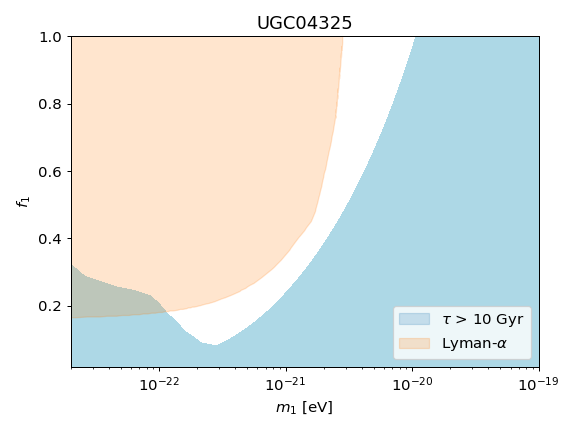

In [128]:
#gal = data2['NGC0100']
gal = data2['UGC04325']
#gal = data2['UGC01281']
#gal = data2['NGC3769']
#gal = data2['NGC3877']
#gal = data2['NGC6503']

m2 = 1.e-23 # [eV]
#f2 = 0.15
m1_arr = np.logspace(-25.2, -18.8, 50)
f1_arr = np.linspace(0., 1., 50)

m1_mesh, f1_mesh = np.meshgrid(m1_arr, f1_arr, indexing='ij')
m1_flat, f1_flat = m1_mesh.reshape(-1), f1_mesh.reshape(-1)

tau1_flat = []
tau1_self_flat = []
r_over_rc = 10

cut_log = True

for i in range(len(m1_flat)):
    m1 = m1_flat[i]
    f1 = f1_flat[i]
    f2 = 1.-f1
    tau1 = 1./(1./model.relaxation_at_rc(m1, gal, f1, multiplier=r_over_rc, cut_log=cut_log) 
               + 1./model.relaxation_at_rc(m2, gal, f2, multiplier=r_over_rc, cut_log=cut_log))
    tau1_flat.append(tau1)
    
    tau1_self = model.relaxation_at_rc(m1, gal, f1, multiplier=r_over_rc, cut_log=cut_log) 
    tau1_self_flat.append(tau1_self)

    
tau1_flat = np.asarray(tau1_flat)
tau1_self_flat = np.asarray(tau1_self_flat)

tau1_mesh = tau1_flat.reshape(m1_mesh.shape)
tau1_self_mesh = tau1_self_flat.reshape(m1_mesh.shape)



_, ax = plt.subplots()
#plt.contourf(m1_mesh, f1_mesh, tau1_mesh, levels=[10, np.inf], colors='lightblue')
plt.contourf(m1_mesh, f1_mesh, tau1_self_mesh, levels=[10, np.inf], colors='lightblue')
plt.fill_between([1,2], 101, 100, color='C0', label=r"$\tau$ > 10 Gyr", alpha=0.2)


#label
#plt.text(2e-23, 1e-22, r"Lyman-$\alpha$", color='red', fontsize=14)
#plt.text(3e-21, 0.5, r"$\tau$ > 10 Gyr", color='blue', fontsize=14)


plt.xscale('log')
#plt.yscale('log')
plt.xlabel('$m_1$ [eV]')
#plt.ylabel('$m_2$ [eV],  15% of total mass')
plt.ylabel(r'$f_1$')
plt.xlim(2e-23, 1e-19)
plt.ylim(0.02, 1.)

# overlay with Kobayashi
path = '../data/Kobayashi2017.csv'
data_lym_arr = np.loadtxt(path, delimiter=',')
x = data_lym_arr[:,0]
y = data_lym_arr[:,1]
x = np.insert(x, 0, 1e-25)
y = np.insert(y, 0, y[0])
plt.fill_between(x, y, 100, color='C1', label=r'Lyman-$\alpha$', alpha=0.2)
plt.legend(loc=4)


ax.set_aspect(aspect=0.618)
plt.title('%s' %gal.name)
plt.tight_layout()
plt.savefig('./plots/relaxation_time_f1_m1_%s.pdf' %gal.name)

<IPython.core.display.Javascript object>


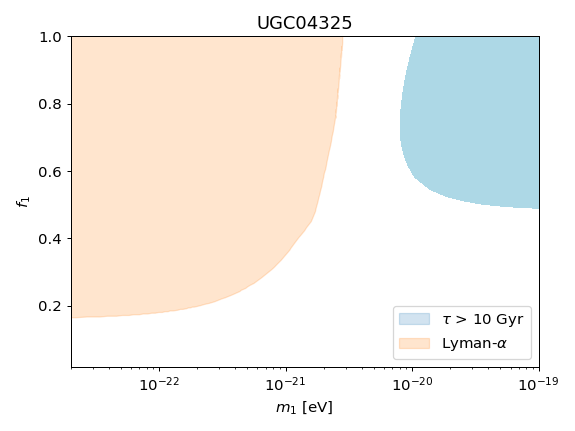

In [129]:
#gal = data2['NGC0100']
gal = data2['UGC04325']
#gal = data2['UGC01281']
#gal = data2['NGC3769']
#gal = data2['NGC3877']
#gal = data2['NGC6503']

m2 = 1.e-23 # [eV]
#f2 = 0.15
m1_arr = np.logspace(-25.2, -18.8, 50)
f1_arr = np.linspace(0., 1., 50)

m1_mesh, f1_mesh = np.meshgrid(m1_arr, f1_arr, indexing='ij')
m1_flat, f1_flat = m1_mesh.reshape(-1), f1_mesh.reshape(-1)

tau1_flat = []
tau1_self_flat = []
r_over_rc = 10

cut_log = True

for i in range(len(m1_flat)):
    m1 = m1_flat[i]
    f1 = f1_flat[i]
    f2 = 1.-f1
    tau1 = 1./(1./model.relaxation_at_rc(m1, gal, f1, multiplier=r_over_rc, cut_log=cut_log) 
               + 1./model.relaxation_at_rc(m2, gal, f2, multiplier=r_over_rc, cut_log=cut_log))
    tau1_flat.append(tau1)
    
    tau1_self = model.relaxation_at_rc(m1, gal, f1, multiplier=r_over_rc, cut_log=cut_log) 
    tau1_self_flat.append(tau1_self)

    
tau1_flat = np.asarray(tau1_flat)
tau1_self_flat = np.asarray(tau1_self_flat)

tau1_mesh = tau1_flat.reshape(m1_mesh.shape)
tau1_self_mesh = tau1_self_flat.reshape(m1_mesh.shape)



_, ax = plt.subplots()
plt.contourf(m1_mesh, f1_mesh, tau1_mesh, levels=[10, np.inf], colors='lightblue')
#plt.contourf(m1_mesh, f1_mesh, tau1_self_mesh, levels=[10, np.inf], colors='lightblue')
plt.fill_between([1,2], 101, 100, color='C0', label=r"$\tau$ > 10 Gyr", alpha=0.2)


#label
#plt.text(2e-23, 1e-22, r"Lyman-$\alpha$", color='red', fontsize=14)
#plt.text(3e-21, 0.5, r"$\tau$ > 10 Gyr", color='blue', fontsize=14)


plt.xscale('log')
#plt.yscale('log')
plt.xlabel('$m_1$ [eV]')
#plt.ylabel('$m_2$ [eV],  15% of total mass')
plt.ylabel(r'$f_1$')
plt.xlim(2e-23, 1e-19)
plt.ylim(0.02, 1.)

# overlay with Kobayashi
path = '../data/Kobayashi2017.csv'
data_lym_arr = np.loadtxt(path, delimiter=',')
x = data_lym_arr[:,0]
y = data_lym_arr[:,1]
x = np.insert(x, 0, 1e-25)
y = np.insert(y, 0, y[0])
plt.fill_between(x, y, 100, color='C1', label=r'Lyman-$\alpha$', alpha=0.2)
plt.legend(loc=4)


ax.set_aspect(aspect=0.618)
plt.title('%s' %gal.name)
plt.tight_layout()

plt.savefig('./plots/relaxation_time_f1_m1_two_species_%s.pdf' %gal.name)

### velocity dispersion

<IPython.core.display.Javascript object>


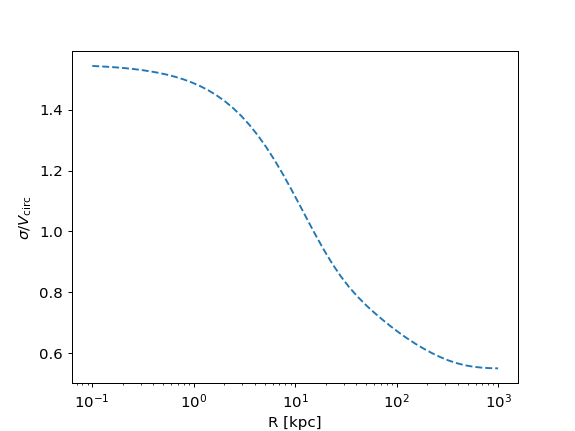

Text(0,0.5,'$\\sigma/V_{\\rm circ}$')

In [137]:
gal = data2['NGC0100']

R = np.logspace(-1, 3)
#y = model.sigma_disp(gal, R, get_array=False)

# debug interp
#y_npinterp = model.sigma_disp_over_vcirc(gal, R)

# no interp
ratio_arr = model.sigma_disp_over_vcirc(gal, R)

plt.subplots()
#plt.plot(R, y)
#plt.plot(R, y_npinterp)
plt.plot(R, ratio_arr, '--')
plt.xscale('log')
#plt.yscale('log')
plt.xlabel('R [kpc]')
plt.ylabel(r'$\sigma/V_{\rm circ}$')

# The Comloub Log

In [ ]:
# plot out to check

<IPython.core.display.Javascript object>


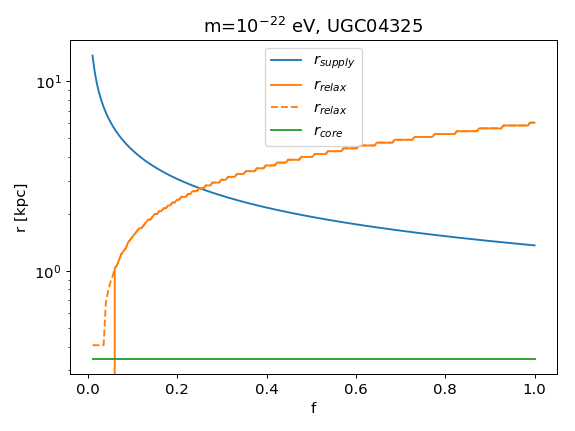

-22.0


In [9]:
gal = spc.findGalaxyByName('UGC04325', data) 

interpol_method = 'linear' #nearest

f_arr = np.linspace(0.01, 1, 200)
#m = 2e-23
#m = 1.3e-23
m = 1e-22
#m = 1e-21
r_supply_arr = np.array([model.supply_radius(f, m, gal) for f in f_arr])
r_relax_arr = np.array([model.relax_radius(f, m, gal, interpol_method=interpol_method) for f in  f_arr])
r_relax_arr2 = np.array([model.relax_radius(f, m, gal, interpol_method=interpol_method, cut_log=False) for f in  f_arr])
r_core_arr = np.array([1.9 * model.rc(m, model.M_SH(m, gal)) for f in  f_arr])

plt.subplots()
plt.plot(f_arr, r_supply_arr, label=r'$r_{supply}$')
plt.plot(f_arr, r_relax_arr, label=r'$r_{relax}$')
plt.plot(f_arr, r_relax_arr2, '--', label=r'$r_{relax}$', color='C1')
plt.plot(f_arr, r_core_arr, label=r'$r_{core}$')

#plt.xscale('log')
plt.yscale('log')
plt.ylabel('r [kpc]')
plt.xlabel('f')
#plt.title('m=%.1e eV, %s' %(m, gal.name))
plt.title('m=%s eV, %s' %(tl.scientific(m), gal.name))
plt.legend(loc='best')
plt.tight_layout()

#plt.savefig('./plots/r_comparison_%s.pdf' %(gal.name))